In [72]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
import matplotlib.pyplot as plt
from skimage.draw import line
from PIL import Image as im
from matplotlib import cm
from skimage import data
import numpy as np
import imageio
import os 

class edgedetector:
  ''' A class implementation for line detection and blurring image if line is detected '''
  
  def open_image(self,imgpath) -> np.array:
    ''' a function that takes the image path,load the raw image and returns a numpy array '''
    assert os.path.exists(imgpath),'please enter a valid path'
    img   = np.array(im.open(imgpath))
    return img
  
  def image_shape(self,imgpath) -> tuple:
    ''' A function to return the iamge shape'''
    assert os.path.exists(imgpath),'please enter a valid path'
    return imageio.imread(imgpath).shape
  
  def display_img(self,img) -> None:
    imgdata = im.fromarray(img)
    plt.imshow(imgdata, cmap=plt.cm.gray)
  
  #Blurring an image by applying a gaussian filter 
  def gaussian_filter(self,img) -> np.array:
    ken = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
    ken = ken / np.sum(ken)
    arraylist = []
    for y in range(3):
        temparray = np.copy(img)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*ken[y,x]
            arraylist.append(temparray_X)

    arraylist   = np.array(arraylist)
    img         = np.sum(arraylist, axis=0)
    return img/255.0

  def rgb2gray(self,gray_img) -> np.array:
    gray_img = np.zeros(img.shape)
    R = np.array(img[:, :, 0])
    G = np.array(img[:, :, 1])
    B = np.array(img[:, :, 2])

    R = (R *.299)
    G = (G *.587)
    B = (B *.114)

    Avg = (R+G+B)
    gray_img = img

    for i in range(3):
        gray_img[:,:,i] = Avg

    return gray_img[:,:,0]
  
  def binarize_img(self,grey_img,threshold=128,maxval=255) -> np.array:
    img   = (grey_img>threshold)*maxval 
    return img.astype(np.uint8)

  def hough_line(self,img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
      x = x_idxs[i]
      y = y_idxs[i]

      for t_idx in range(num_thetas):
        # Calculate rho. diag_len is added for a positive index
        rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
        accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos
  


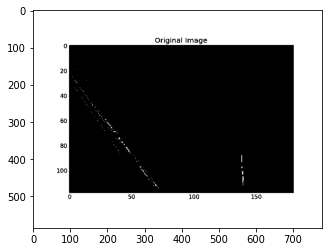

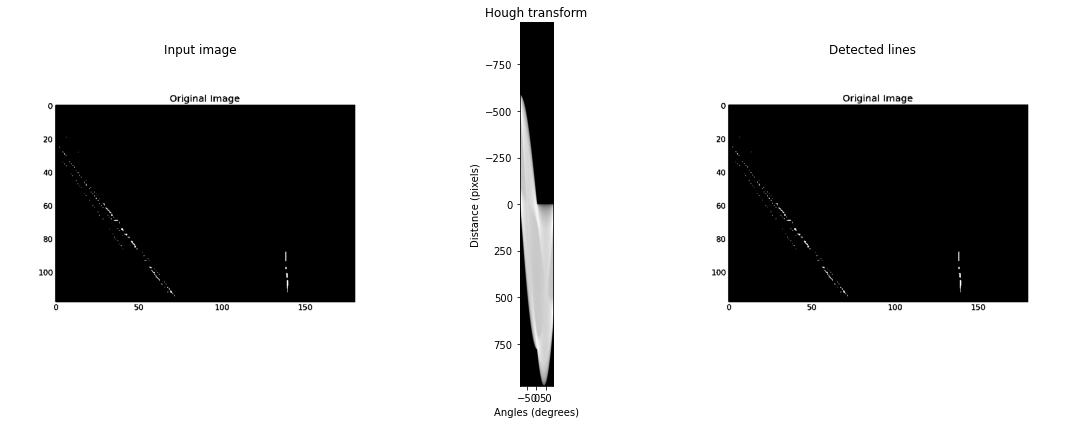

In [76]:
ed  = edgedetector()
img = ed.open_image('/content/hello.png')
img = ed.rgb2gray(img)
img = ed.binarize_img(img,threshold=200)
ed.display_img(img)
h, theta, d = ed.hough_line(img)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()